In [ ]:
import pandas as pd

# ---------- 1. Load data ----------

agents = pd.read_csv("/agents.csv")
customers = pd.read_csv("/customers.csv")
entertainers = pd.read_csv("/entertainers.csv")
members = pd.read_csv("/members.csv")
engagements = pd.read_csv("/engagements.csv")
entertainer_styles = pd.read_csv("/entertainer_styles.csv")
entertainer_members = pd.read_csv("/entertainer_members.csv")
musical_styles = pd.read_csv("/musical_styles.csv")
musical_preferences = pd.read_csv("/musical_preferences.csv")

tables = {
    "agents": agents,
    "customers": customers,
    "entertainers": entertainers,
    "members": members,
    "engagements": engagements,
    "entertainer_styles": entertainer_styles,
    "entertainer_members": entertainer_members,
    "musical_styles": musical_styles,
    "musical_preferences": musical_preferences,
}

# ---------- 2. Missing value checks ----------

print("=== Missing value summary for each table ===")
for name, df in tables.items():
    print(f"\n{name}")
    print(df.isna().sum())


# ---------- 3. Duplicate checks ----------

print("\n=== Duplicate row checks ===")
for name, df in tables.items():
    dup_count = df.duplicated().sum()
    print(f"{name}: {dup_count} fully duplicated rows")

# Check composite keys for relationship tables (use lowercase column names)

print("\nEntertainer_Styles duplicated (entertainerid, styleid):",
      entertainer_styles.duplicated(subset=["entertainerid", "styleid"]).sum())

print("Entertainer_Members duplicated (entertainerid, memberid):",
      entertainer_members.duplicated(subset=["entertainerid", "memberid"]).sum())

print("Musical_Preferences duplicated (customerid, styleid, preferenceseq):",
      musical_preferences.duplicated(subset=["customerid", "styleid", "preferenceseq"]).sum())



# ---------- 4. Basic outlier / invalid value checks ----------

# 4.1 Agent salary & commission rate

print("\n=== Agents: salary summary ===")
print(agents["salary"].describe())

suspicious_salary = agents[
    (agents["salary"] < 0) | (agents["salary"] < 1000) | (agents["salary"] > 100000)
]
print("\nAgents with suspicious salaries (possible outliers):")
print(suspicious_salary)

print("\n=== Agents: commission rate outside [0, 1] ===")
print(agents[(agents["commissionrate"] < 0) | (agents["commissionrate"] > 1)])


# 4.2 contractprice in engagements (lowercase column name)
print("\n=== Engagements: contractprice summary ===")
print(engagements["contractprice"].describe())

print("\nEngagements with non-positive contractprice:")
print(engagements[engagements["contractprice"] <= 0])


# 4.3 StyleStrength & PreferenceSeq
print("\nEntertainer_Styles with stylestrength outside [1, 10]:")
print(entertainer_styles[(entertainer_styles["stylestrength"] < 1) |
                         (entertainer_styles["stylestrength"] > 10)])

print("\nMusical_Preferences with PreferenceSeq <= 0:")
print(musical_preferences[musical_preferences["preferenceseq"] <= 0])



# ---------- 5. Referential integrity checks (foreign keys, use lowercase) ----------

# Engagements → Customers
eng_cust = engagements.merge(
    customers[["customerid"]],
    on="customerid",
    how="left",
    indicator=True
)
print("\nEngagements referencing missing customers:",
      (eng_cust["_merge"] == "left_only").sum())

# Engagements → Agents
eng_agent = engagements.merge(
    agents[["agentid"]],
    on="agentid",
    how="left",
    indicator=True
)
print("Engagements referencing missing agents:",
      (eng_agent["_merge"] == "left_only").sum())

# Engagements → Entertainers
eng_ent = engagements.merge(
    entertainers[["entertainerid"]],
    on="entertainerid",
    how="left",
    indicator=True
)
print("Engagements referencing missing entertainers:",
      (eng_ent["_merge"] == "left_only").sum())

# Entertainer_Members → Entertainers
em_ent = entertainer_members.merge(
    entertainers[["entertainerid"]],
    on="entertainerid",
    how="left",
    indicator=True
)
print("Entertainer_Members with missing entertainers:",
      (em_ent["_merge"] == "left_only").sum())

# Entertainer_Members → Members
em_mbr = entertainer_members.merge(
    members[["memberid"]],
    on="memberid",
    how="left",
    indicator=True
)
print("Entertainer_Members with missing members:",
      (em_mbr["_merge"] == "left_only").sum())

# Entertainer_Styles → Entertainers
es_ent = entertainer_styles.merge(
    entertainers[["entertainerid"]],
    on="entertainerid",
    how="left",
    indicator=True
)
print("Entertainer_Styles with missing entertainers:",
      (es_ent["_merge"] == "left_only").sum())

# Entertainer_Styles → Musical_Styles
es_style = entertainer_styles.merge(
    musical_styles[["styleid"]],
    on="styleid",
    how="left",
    indicator=True
)
print("Entertainer_Styles with missing styles:",
      (es_style["_merge"] == "left_only").sum())



# ---------- 6. Create cleaned versions for analysis ----------

# Here we do *light* cleaning: we don't modify raw data,
# but we define cleaned DataFrames that exclude obviously bad records.

# ---------- 6. Create cleaned versions for analysis (use lowercase column names) ----------

clean_agents = agents.copy()
# drop unrealistic salaries if you decide they are errors (e.g., < 1000)
clean_agents = clean_agents[clean_agents["salary"] >= 1000]

clean_engagements = engagements.copy()
# drop non-positive prices
clean_engagements = clean_engagements[clean_engagements["contractprice"] > 0]

clean_entertainer_styles = entertainer_styles.copy()
clean_entertainer_styles = clean_entertainer_styles[
    (clean_entertainer_styles["stylestrength"] >= 1)
    & (clean_entertainer_styles["stylestrength"] <= 10)
]

clean_musical_preferences = musical_preferences.copy()
clean_musical_preferences = clean_musical_preferences[
    clean_musical_preferences["preferenceseq"] > 0
]

clean_customers = customers.copy()
clean_customers["custphonenumber"] = clean_customers["custphonenumber"].fillna("Unknown")

clean_tables = {
    "agents": clean_agents,
    "customers": clean_customers,
    "entertainers": entertainers,
    "members": members,
    "engagements": clean_engagements,
    "entertainer_styles": clean_entertainer_styles,
    "entertainer_members": entertainer_members,
    "musical_styles": musical_styles,
    "musical_preferences": clean_musical_preferences,
}

print("\n=== Cleaning finished. Cleaned tables ready for EDA. ===")
for name, df in clean_tables.items():
    print(f"{name}: {df.shape[0]} rows")



=== Missing value summary for each table ===

agents
agentid             0
agtfirstname        0
agtlastname         0
agtstreetaddress    0
agtcity             0
agtstate            0
agtzipcode          0
agtphonenumber      0
datehired           0
salary              0
commissionrate      0
dtype: int64

customers
customerid           0
custfirstname        0
custlastname         0
custstreetaddress    0
custcity             0
custstate            0
custzipcode          0
custphonenumber      0
dtype: int64

entertainers
entertainerid       0
entstagename        0
entssn              0
entstreetaddress    0
entcity             0
entstate            0
entzipcode          0
entphonenumber      0
entwebpage          5
entemailaddress     6
dateentered         0
dtype: int64

members
memberid          0
mbrfirstname      0
mbrlastname       0
mbrphonenumber    0
gender            1
dtype: int64

engagements
engagementnumber    0
startdate           0
enddate             0
starttime     

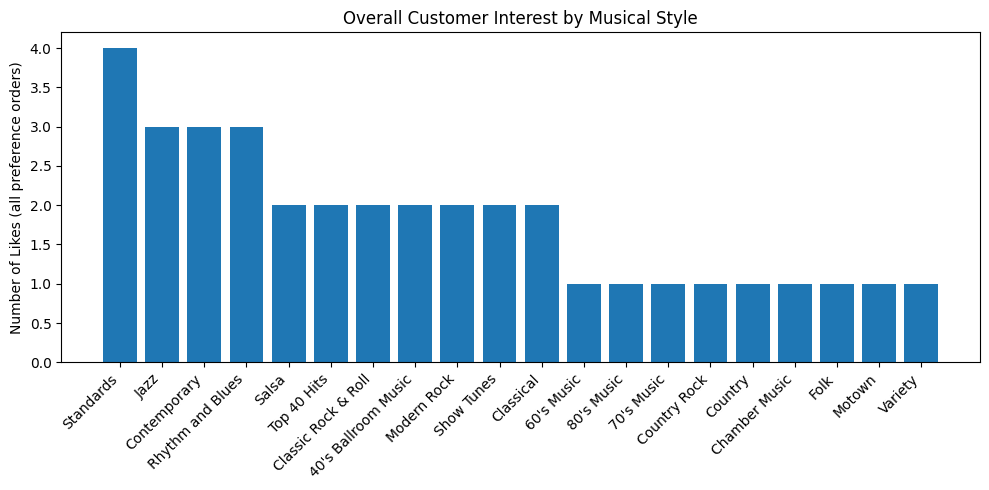

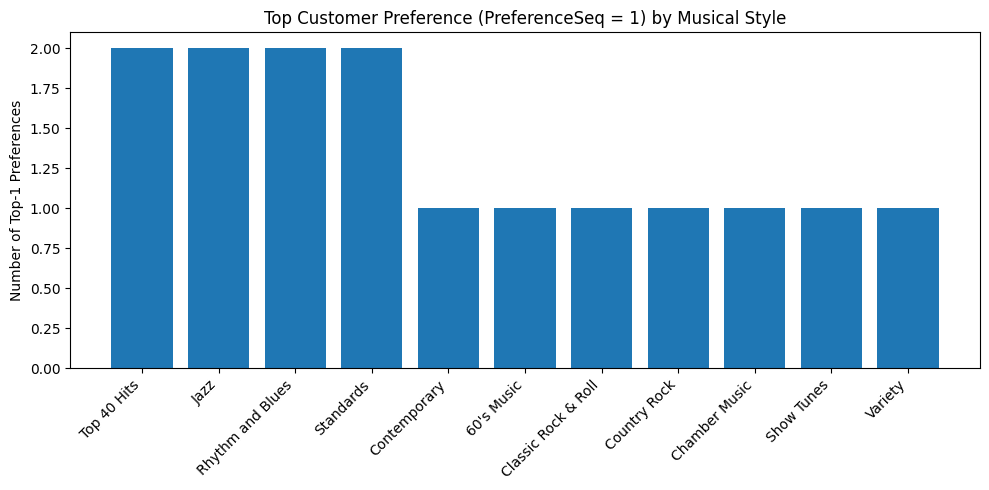

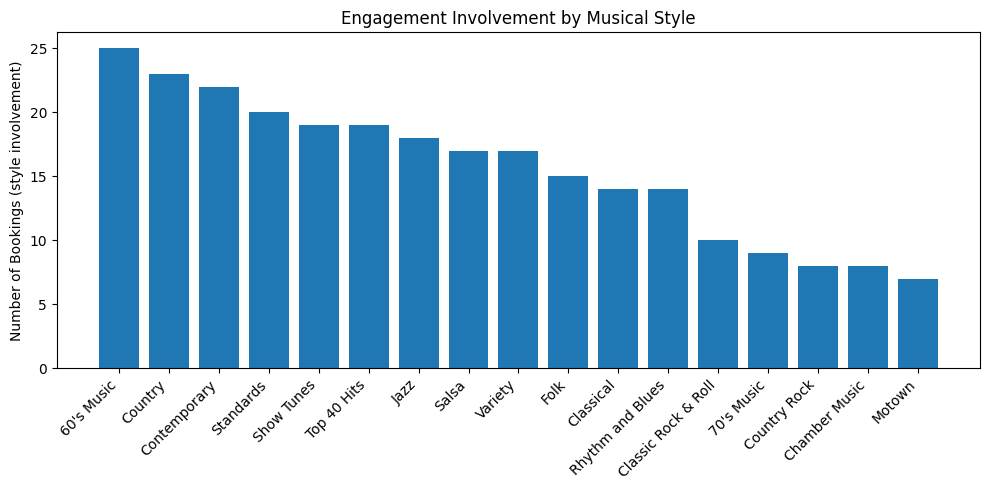

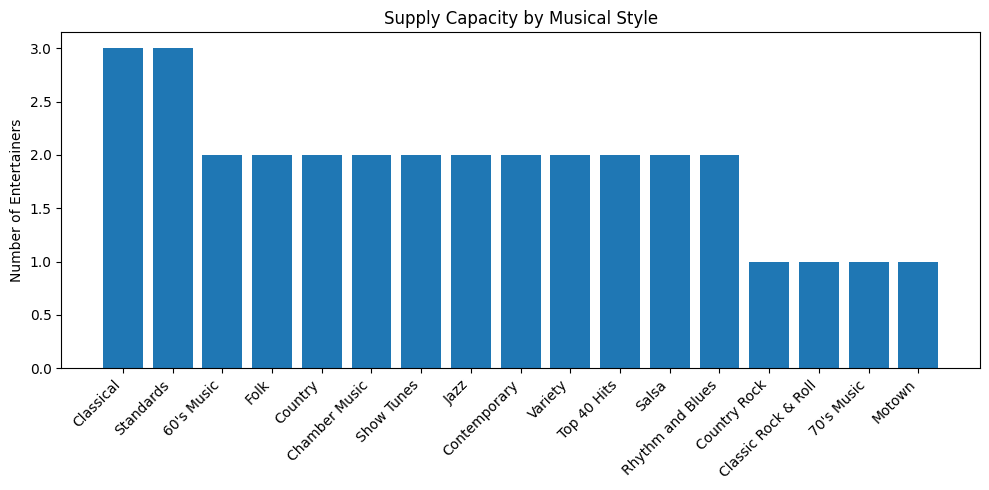

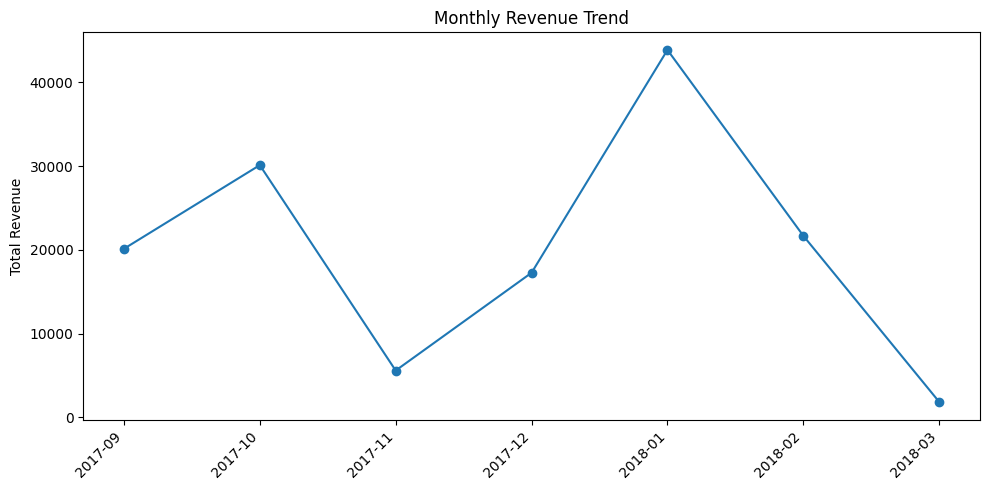

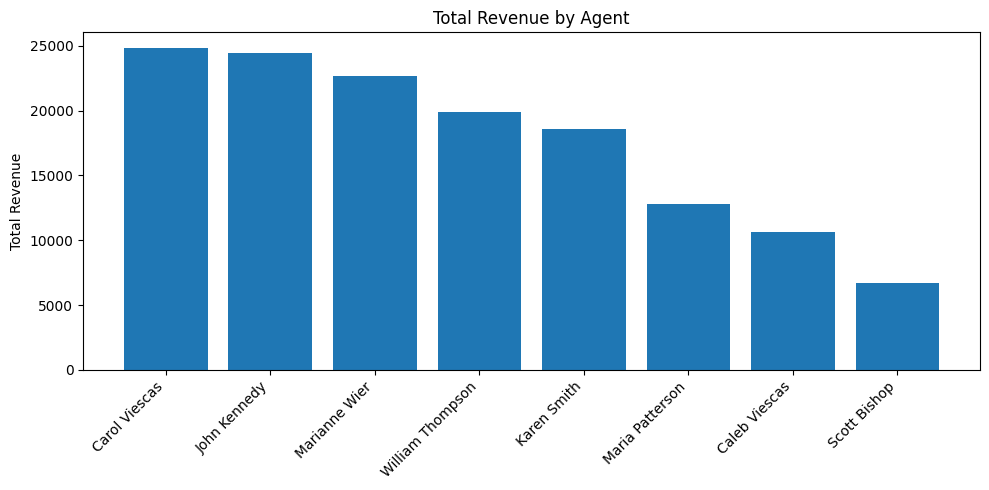

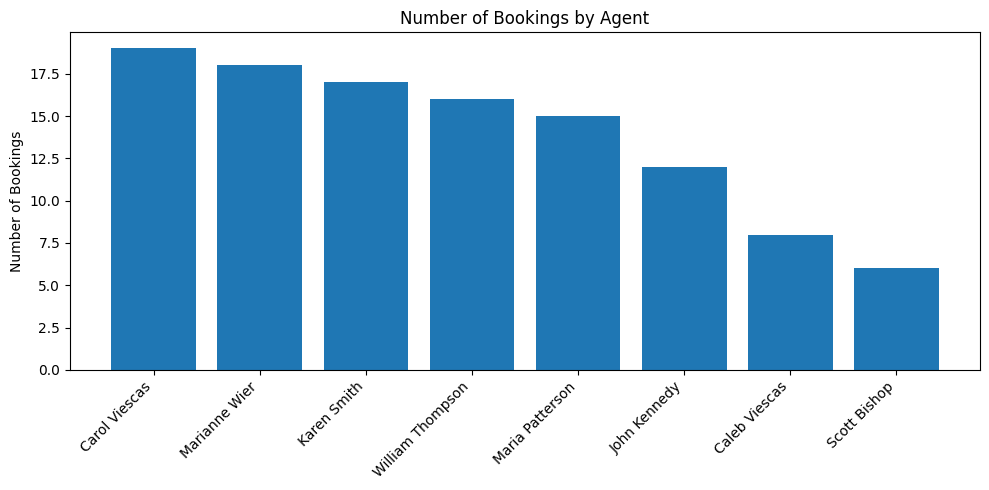

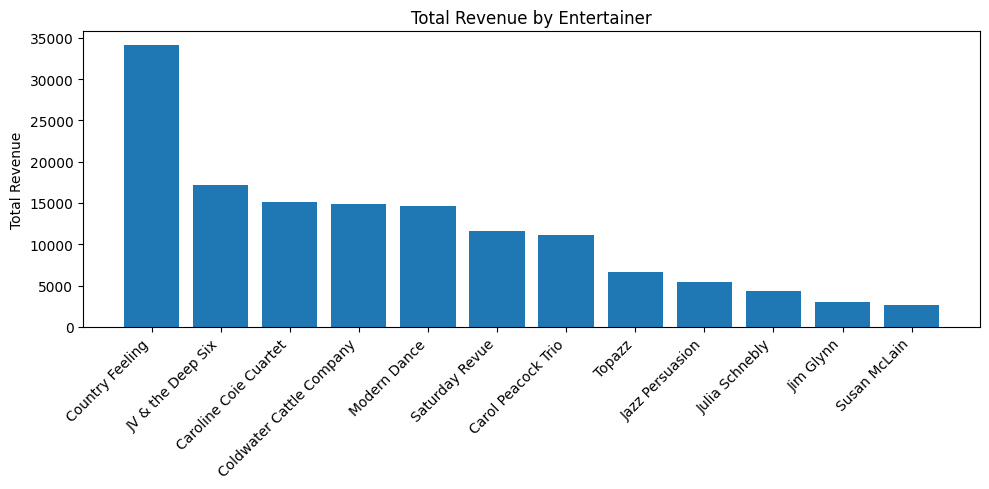

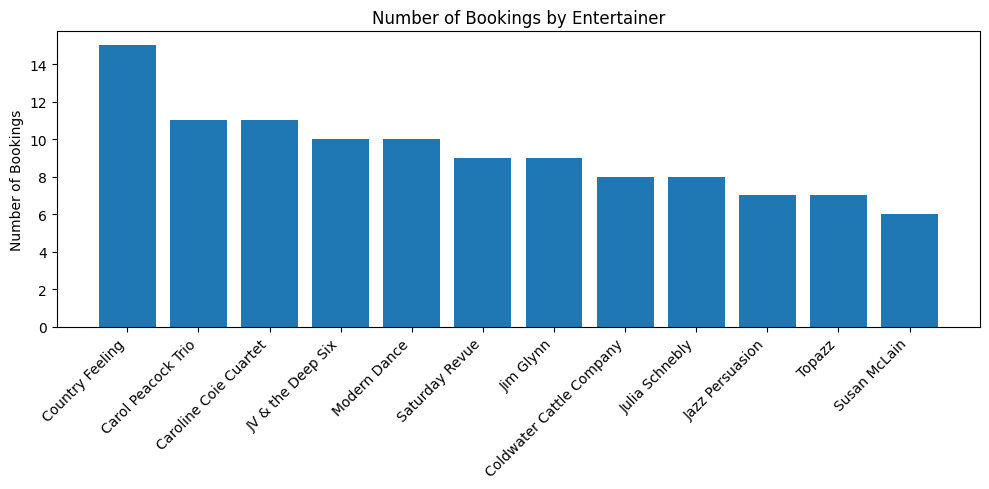

All visualizations generated using cleaned data.


In [ ]:
import matplotlib.pyplot as plt

# ================
# Helper: attach style name
# ================
def add_style_name(df, style_col="styleid"):
    return df.merge(
        musical_styles[["styleid", "stylename"]],
        left_on=style_col,
        right_on="styleid",
        how="left"
    )

# =========================
# 1. Musical Style Popularity
# =========================

# 1.1 Overall likes per style (all preferenceSeq)
overall_likes = (
    clean_musical_preferences
    .groupby("styleid")
    .size()
    .reset_index(name="overall_likes")
)
overall_likes = add_style_name(overall_likes)

overall_likes_sorted = overall_likes.sort_values("overall_likes", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(overall_likes_sorted["stylename"], overall_likes_sorted["overall_likes"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Likes (all preference orders)")
plt.title("Overall Customer Interest by Musical Style")
plt.tight_layout()
plt.show()

# 1.2 Top-1 likes per style (PreferenceSeq = 1)
top1_likes = (
    clean_musical_preferences[clean_musical_preferences["preferenceseq"] == 1]
    .groupby("styleid")
    .size()
    .reset_index(name="top1_likes")
)
top1_likes = add_style_name(top1_likes)

top1_likes_sorted = top1_likes.sort_values("top1_likes", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(top1_likes_sorted["stylename"], top1_likes_sorted["top1_likes"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Top-1 Preferences")
plt.title("Top Customer Preference (PreferenceSeq = 1) by Musical Style")
plt.tight_layout()
plt.show()

# 1.3 Bookings per style (style involvement in engagements)
eng_styles = clean_engagements.merge(
    clean_entertainer_styles,
    on="entertainerid",
    how="inner"
)

bookings_per_style = (
    eng_styles
    .groupby("styleid")
    .size()
    .reset_index(name="num_bookings")
)
bookings_per_style = add_style_name(bookings_per_style)

bookings_sorted = bookings_per_style.sort_values("num_bookings", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(bookings_sorted["stylename"], bookings_sorted["num_bookings"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Bookings (style involvement)")
plt.title("Engagement Involvement by Musical Style")
plt.tight_layout()
plt.show()

# 1.4 Supply: number of entertainers per style
supply_per_style = (
    clean_entertainer_styles
    .groupby("styleid")["entertainerid"]
    .nunique()
    .reset_index(name="num_supply")
)
supply_per_style = add_style_name(supply_per_style)

supply_sorted = supply_per_style.sort_values("num_supply", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(supply_sorted["stylename"], supply_sorted["num_supply"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Entertainers")
plt.title("Supply Capacity by Musical Style")
plt.tight_layout()
plt.show()

# =========================
# 2. Monthly Revenue Trend
# =========================

clean_engagements["startdate"] = pd.to_datetime(clean_engagements["startdate"])

clean_engagements["year_month"] = (
    clean_engagements["startdate"].dt.to_period("M").astype(str)
)

monthly_revenue = (
    clean_engagements
    .groupby("year_month")["contractprice"]
    .sum()
    .reset_index(name="total_revenue")
)

monthly_revenue_sorted = monthly_revenue.sort_values("year_month")

plt.figure(figsize=(10, 5))
plt.plot(
    monthly_revenue_sorted["year_month"],
    monthly_revenue_sorted["total_revenue"],
    marker="o"
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Revenue")
plt.title("Monthly Revenue Trend")
plt.tight_layout()
plt.show()

# =========================
# 3. Agent Performance
# =========================

eng_agent = clean_engagements.merge(
    clean_agents[["agentid", "agtfirstname", "agtlastname"]],
    on="agentid",
    how="left"
)
eng_agent["agent_name"] = eng_agent["agtfirstname"] + " " + eng_agent["agtlastname"]

# 3.1 Revenue per agent
revenue_per_agent = (
    eng_agent
    .groupby("agent_name")["contractprice"]
    .sum()
    .reset_index(name="total_revenue")
)
revenue_per_agent_sorted = revenue_per_agent.sort_values("total_revenue", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(revenue_per_agent_sorted["agent_name"], revenue_per_agent_sorted["total_revenue"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Revenue")
plt.title("Total Revenue by Agent")
plt.tight_layout()
plt.show()

# 3.2 Number of bookings per agent
bookings_per_agent = (
    eng_agent
    .groupby("agent_name")["engagementnumber"]
    .nunique()
    .reset_index(name="num_bookings")
)
bookings_per_agent_sorted = bookings_per_agent.sort_values("num_bookings", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(bookings_per_agent_sorted["agent_name"], bookings_per_agent_sorted["num_bookings"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Bookings")
plt.title("Number of Bookings by Agent")
plt.tight_layout()
plt.show()

# =========================
# 4. Entertainer Performance
# =========================

eng_ent = clean_engagements.merge(
    entertainers[["entertainerid", "entstagename"]],
    on="entertainerid",
    how="left"
)

# 4.1 Revenue per entertainer
revenue_per_entertainer = (
    eng_ent
    .groupby("entstagename")["contractprice"]
    .sum()
    .reset_index(name="total_revenue")
)
revenue_per_entertainer_sorted = revenue_per_entertainer.sort_values(
    "total_revenue", ascending=False
)

plt.figure(figsize=(10, 5))
plt.bar(
    revenue_per_entertainer_sorted["entstagename"],
    revenue_per_entertainer_sorted["total_revenue"]
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Revenue")
plt.title("Total Revenue by Entertainer")
plt.tight_layout()
plt.show()

# 4.2 Number of bookings per entertainer
bookings_per_entertainer = (
    eng_ent
    .groupby("entstagename")["engagementnumber"]
    .nunique()
    .reset_index(name="num_bookings")
)
bookings_per_entertainer_sorted = bookings_per_entertainer.sort_values(
    "num_bookings", ascending=False
)

plt.figure(figsize=(10, 5))
plt.bar(
    bookings_per_entertainer_sorted["entstagename"],
    bookings_per_entertainer_sorted["num_bookings"]
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Bookings")
plt.title("Number of Bookings by Entertainer")
plt.tight_layout()
plt.show()

print("All visualizations generated using cleaned data.")
